In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

In [3]:
from cpymad.madx import Madx

import pysixtracklib as pyst

In [4]:
madx = Madx()
madx.options.echo = False
# madx.options.warn = False
# madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.21 16:54:40      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
!grep "sequence" ./SIS100_RF_220618_9slices.thin.seq

In [6]:
madx.call('./SIS100_RF_220618_9slices.thin.seq')

++++++ warning: implicit element re-definition ignored: startpoint
++++++ warning: implicit element re-definition ignored: sector_1
++++++ warning: implicit element re-definition ignored: cell_11
++++++ warning: implicit element re-definition ignored: s11hcb1s_en
++++++ warning: implicit element re-definition ignored: s11hcb1s_ex
++++++ warning: implicit element re-definition ignored: cell_12
++++++ warning: implicit element re-definition ignored: s12hcscv_en
++++++ warning: implicit element re-definition ignored: s12hcscv_ex
++++++ warning: implicit element re-definition ignored: s12hcsb2s_en
++++++ warning: implicit element re-definition ignored: s12hcsb2s_ex
++++++ warning: implicit element re-definition ignored: cell_13
++++++ warning: implicit element re-definition ignored: cell_14
++++++ warning: implicit element re-definition ignored: s14km1
++++++ warning: implicit element re-definition ignored: cell_15
++++++ warning: implicit element re-definition ignored: s15ds1_en
++++++ wa

In [7]:
from scipy.constants import physical_constants

In [8]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [9]:
madx.command.beam(particle='ion', mass=238*nmass, charge=28, energy=238*0.2+238*nmass)

True

In [10]:
madx.call('./OpticsYEH_BeamParameters.str')

++++++ warning: ignored: attempt to redefine constant: lqd
++++++ info: harmonic_number redefined
++++++ info: cavity_voltage redefined
++++++ info: k0sl_mke1 redefined
++++++ info: k0sl_s51mk1e redefined
++++++ info: k0sl_s52mk1e redefined
++++++ info: k0sl_s53mk1e redefined
++++++ info: k0sl_mke2 redefined
++++++ info: k0sl_s51mk2e redefined
++++++ info: k0sl_s52mk2e redefined
++++++ info: k0sl_s53mk2e redefined
++++++ info: k0sl_mke3 redefined
++++++ info: k0sl_s51mk3e redefined
++++++ info: k0sl_s53mk3e redefined
++++++ info: kqd redefined
++++++ info: kqf redefined
++++++ info: k1nl_s00qd1d redefined
++++++ info: k1nl_s00qd1f redefined
++++++ info: k1nl_s00qd2f redefined
++++++ info: k1nl_s52qd11 redefined
++++++ info: k1nl_s52qd12 redefined
++++++ info: k2nl_kse redefined
++++++ info: k2nl_s14ks1e redefined
++++++ info: k2nl_s24ks1e redefined
++++++ info: k2nl_s34ks1e redefined
++++++ info: k2nl_s44ks1e redefined
++++++ info: k2nl_s54ks1e redefined
++++++ info: k2nl_s64ks1e redef

In [11]:
#madx.call('Coll+Errors+BeamDistr.madx')

In [12]:
#madx.call('Beam, sequence=SIS100RING, particle=U28, charge=charge_proj, mass=mass_proj, energy=energy_tot;')

In [13]:
madx.use(sequence='sis100ring')

In [14]:
#madx.call(file='track-noSpCh.madx')

In [15]:
madx.input('''
match, sequence=SIS100RING;
global, sequence=SIS100RING, q1=18+0.84, q2=18+0.73;
vary, name=kqf, step=0.00001;
vary, name=kqd, step=0.00001;
lmdif, calls=500, tolerance=1.0e-10;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   8.49283167e-16





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80997e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.79858e-01 -2.80616e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   8.49283167e-16


True

In [16]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004051660019        15.71026469 

                q1                dq1            betxmax              dxmax 
             18.84       -39.80511805        19.95816218        3.140998962 

             dxrms             xcomax             xcorms                 q2 
        1.38648703                  0                  0              18.73 

               dq2            betymax              dymax              dyrms 
      -39.71639486        21.30632346                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [17]:
madx.use(sequence='SIS100RING')

In [18]:
madx.input('''
select, flag=seqedit, class=collimator;
select, flag=seqedit, class=hmonitor;
select, flag=seqedit, class=vmonitor;
select, flag=seqedit, class=kicker;
select, flag=seqedit, class=tkicker;
select, flag=seqedit, class=dipedge;
select, flag=seqedit, class=elseparator;

seqedit, sequence=SIS100RING;
    remove, element=selected;
    flatten;
endedit;

select, flag=seqedit, class=marker;
seqedit, sequence=SIS100RING;
    remove, element=selected;
    install, element=SIS100RING$START, s=0;
    flatten;
endedit;
''')

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    1631
++++++ info: seqedit - number of elements replaced:   0
++++++ warning: ignored, unknown command or element: (null)
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    272
++++++ info: seqedit - number of elements replaced:   0


True

In [19]:
madx.use(sequence='SIS100RING')

In [20]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.003976364178        15.85831075 

                q1                dq1            betxmax              dxmax 
       18.93447532       -39.84761629        20.36418065        2.974829662 

             dxrms             xcomax             xcorms                 q2 
       1.334406864                  0                  0        18.63571542 

               dq2            betymax              dymax              dyrms 
      -39.79029215        21.84969014                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [21]:
sis100 = madx.sequence.sis100ring

In [22]:
[f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
 if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name]

['marker', 'marker']

In [23]:
elements = pyst.Elements.from_mad(sis100)

In [24]:
len(elements.get_elements())

3607

In [25]:
nturns = 2**16
elements.BeamMonitor(num_stores=nturns);

In [26]:
p0c = 238*0.2 * 1e9

In [27]:
npart = 1
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [28]:
particles.x += 1e-6
particles.y += 1e-6

In [29]:
job = pyst.TrackJob(elements, particles)

In [30]:
job.track(nturns)

0

In [31]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

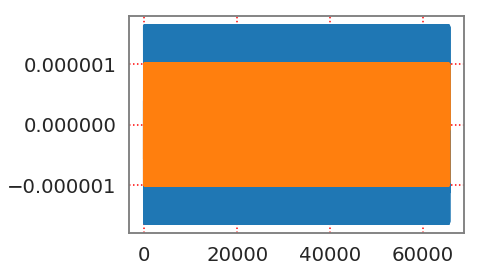

In [32]:
plt.plot(rec_x)
plt.plot(rec_y)

In [33]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

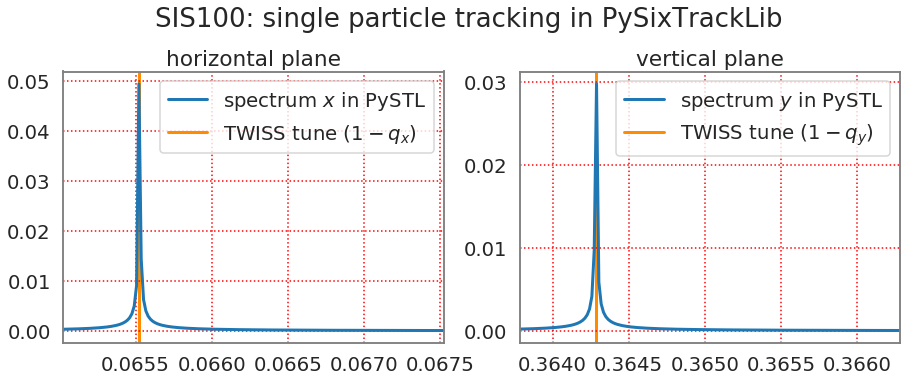

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x)),
    np.abs(np.fft.rfft(rec_x)),
    label=r'spectrum $x$ in PySTL'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.0005, qx + 0.002)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y)),
    np.abs(np.fft.rfft(rec_y)),
    label=r'spectrum $y$ in PySTL'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.0005, qy + 0.002)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26)
plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')